[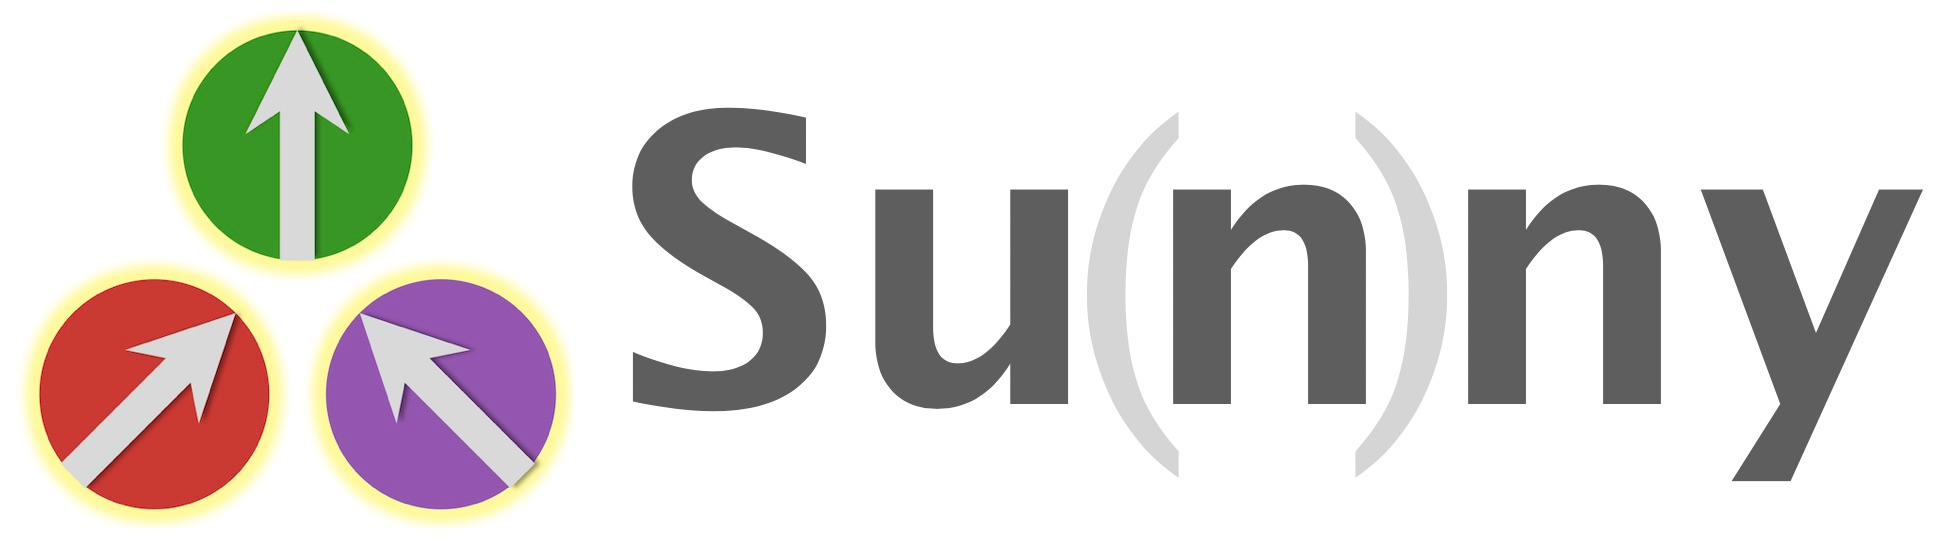](https://github.com/SunnySuite/Sunny.jl/)

_This is a tutorial for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which enables dynamical simulations of spins with dipole and higher order moments._

# SU(3) Case Study: FeI$_{2}$

In this tutorial, we will walk through the process of calculating the dynamical properties of the compound FeI$_2$. This is an effective spin 1 material with strong single-ion anisotropy, making it an excellent candidate for treatment with generalized SU(3) spin dynamics.  Full details about the model can be found in reference [\[1\]](https://doi.org/10.1038/s41567-020-01110-1).

We will begin by importing all the necessary Julia packages. The plotting packages may take a minute to load.

In [ ]:
using Sunny
using GLMakie, Plots, Formatting

Sunny.offline_viewers(); 

## Setting up the Crystal

Sunny has a number of facilities for specifying a crystal. If a CIF file is available, it can be loaded using `Crystal("file.cif")`. Here, instead, we will directly specify the lattice vectors and atom positions for a unit cell.

In [3]:
a = b = 4.05012  # angstroms
c = 6.75214
lat_vecs = lattice_vectors(a, b, c, 90, 90, 120) # This a convenience method. Alternatively,
                                                 # lattice vectors could be specified as
                                                 # columns of a 3x3 matrix.
types = ["Fe", "I", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4], [2/3, 1/3, 3/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


Observe that Sunny inferred the space group `'P -3 m 1'`, corresponding to the international number 164. This is consistent with the table below, taken from reference [1]. Specifying the atom types can sometimes be necessary for Sunny to correctly infer the spacegroup symmetry.

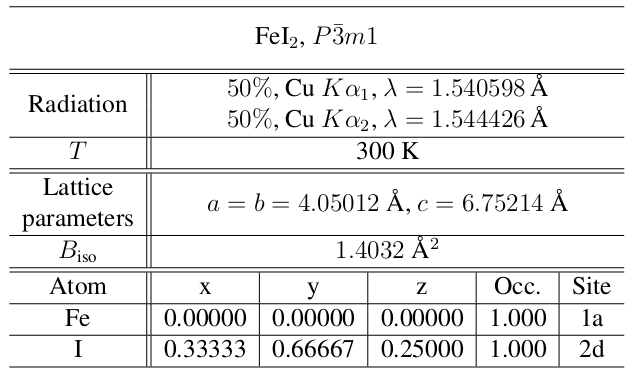

Alternatively, a `Crystal` can be constructed from a given spacegroup, here 164. The second I position will be inferred from the first one by symmetry.

In [4]:
types = ["Fe", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs, 164; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


## 3D Visualization

Sunny provides an interactive tool to visualize the 3D crystal structure, as well as the equivalence classes of "bonds."

In [5]:
view_crystal(cryst, 8.0)  # Second argument is maximum distance

SunnyViewer(...)

Dragging the mouse will rotate the crystal. Shift-dragging will translate. Spinning the mouse wheel (i.e., the window scroll action) will zoom.

Unselect the I checkbox to focus only on the Fe ions. We see that there are four equivalence classes of bonds between Fe ions within the specified radius of 8 Å.

The crystal viewer will be useful in conjunction with specifying interactions between bonds, as described below.

## Specifying Interactions

We now wish to implement the various interactions in the Hamiltonian given in reference [1]. These include 6 different anisotropic exchange interactions as well as a single-ion anisotropy. Each of these interactions must be assigned to a particular bond or particular site of the crystal. Note that it is necessary to specify an interaction only once on a single instance of a bond or site.  Sunny will automatically propagate the interaction to all other symmetry equivalent bonds or sites.

### Exchange interactions
The different bonds on which we wish to specify exchange interactions are illustrated with yellow arrows in the the following illustration \[1\]:


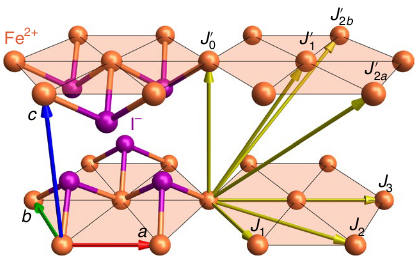

Correctly specifying these six interactions requires some care. Fortunately, Sunny provides tools to help.

Our interest is the magnetic behavior of the Fe ions. We will first restrict to this sublattice, while preserving spacegroup for the full FeI$_2$ crystal.

In [7]:
FeI2_cryst = subcrystal(cryst, "Fe")

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]


Like SpinW, Sunny can perform a symmetry analysis, listing the symmetry-allowed interactions for a representative set of bonds up to some maximum cutoff distance.

In [8]:
print_bond_table(FeI2_cryst, 10.0)

Atom 1, type 'Fe', position [0, 0, 0], multiplicity 1
Allowed single-ion anisotropy or g-tensor: | A  0  0 |
                                           | 0  A  0 |
                                           | 0  0  B |

Bond(1, 1, [1, 0, 0])
Distance 4.0501, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [0, 0, 1])
Distance 6.7521, coordination 2
Connects 'Fe' at [0, 0, 0] to 'Fe' at [0, 0, 1]
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 2, 0])
Distance 7.015, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 2, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [1, 0, 1])
Distance 7.8737, coordination 12
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 0, 1]
Allowed exchange matrix: | A  F  E |

Sunny has provided us with a great deal of useful information here, and it is worth dissecting the results.

The precise syntax for specifying a bond is given at the top of each entry, e.g., `Bond(1, 1, [1, 0, 0])`. The first two arguments specify a pair of sites with an implied orientation (_from_ the first ion _to_ the second). The sites of ions are numbered according to the list provide when making a crystal. Since our cyrstal only contains a single site per unit cell -- the Fe ion -- the first two arguments to `Bond` will always be 1. The list provided as the final argument to `Bond` specifies an offset in terms of lattice vectors. So `Bond(1, 1, [1, 0, 0])` refers to the bond between the same ion in two different unit cells, specifically the unit cell that is offset one `a` lattice vector from the origin.

The length of the bond is given by `Distance`, which is useful for determining different orders of nearest neighbor. The coordinates of both the origin and destination of the bond are given in fractional coordinates. Finally, we should note that Sunny provides the allowed form of any exchange matrix that is assigned to the bond. If you try to give Sunny an exchange matrix that does not match this form, it will not allow you to build your model.

At the very top of the list, Sunny provides the allowed form of a g-tensor or quadratic anisotropy for each unique site. Note that anisotropies for generalized SU(N) spins are analyzed and specified differently than they are for traditional Landau-Lifshitz (LL) dipole dynamics. The information provided in this list refers to traditional dipole models. The specification of SU(_N_) anisotropies is discussed further below.


It is of course possible to work through the bond table and establish a correspondence between different bonds and the figure provided in the paper. For example, we can see that `Bond(1, 1, [1, 0, 0])` refers to $J_1$ in the illustration, since it is the shortest in-plane bond in the table. However, the crystal viewer introduced above can be a great aid in this process, and we encourage the reader to experiment with the viewer to establish correspondences with the information in the bond table. For example, selecting all the `J1` bonds in the crystal viewer will make the hexagonal unit from illustration \[1\] clearly visible.

The command to create an exchange interaction is `exchange(J, bond)`, where `J` is a 3x3 exchange matrix, and `bond` follows the format of `print_bond_table()`. For example, nearest neighbor interactions can be specified using `exch1 = exchange(J, Bond(1, 1, [1, 0, 0]))`. 

We follow this procedure below, assigning the exchange matrices provided in reference [1] to their corresponding bonds in our crystal. We encourage the reader to go through this exercise independently, but the final result is below.

In [9]:
# ---------- Parameters as given in supplementary information ---------- #
J1pm   = -0.236
J1pmpm = -0.161
J1zpm  = -0.261

J2pm   = 0.026

J3pm   = 0.166

J′0pm  = 0.037

J′1pm  = 0.013

J′2apm = 0.068
D      = 2.165

J1zz   = -0.236
J2zz   = 0.113
J3zz   = 0.211
J′0zz  = -0.036
J′1zz  = 0.051
J′2azz = 0.073
J′2bzz = 0.0

# ---------- Parameters transformed into exchange matrices ---------- #
J1xx = J1pm + J1pmpm 
J1yy = J1pm - J1pmpm
J1yz = J1zpm

J₁ = [J1xx  0.0   0.0;
      0.0   J1yy  J1yz;
      0.0   J1yz  J1zz]

J₂ = [J2pm  0.0  0.0;
      0.0   J2pm 0.0;
      0.0   0.0  J2zz]

J₃ = [J3pm   0.0   0.0;
      0.0    J3pm  0.0;
      0.0    0.0   J3zz]

J′₀ = [J′0pm  0.0   0.0;
       0.0    J′0pm 0.0;
       0.0    0.0   J′0zz]

J′₁ = [J′1pm  0.0   0.0;
       0.0    J′1pm 0.0;
       0.0    0.0   J′1zz]

J′₂ = [J′2apm  0.0   0.0;
       0.0    J′2apm 0.0;
       0.0    0.0   J′2azz]


exchange_interactions = [
      exchange(J₁, Bond(1,1,[1,0,0])),
      exchange(J₂, Bond(1,1,[1,2,0])),
      exchange(J₃, Bond(1,1,[2,0,0])),
      exchange(J′₀, Bond(1,1,[0,0,1])),
      exchange(J′₁, Bond(1,1,[1,0,1])),
      exchange(J′₂, Bond(1,1,[1,2,1])),
];

### Onsite Anistropy

In addition to the exchange interactions specified above, the model includes a strong single-ion anisotropy term: $D\left(\hat{S}^z\right)^2$. In SU(_N_) mode, Sunny allows the user to specify the anisotropy directly in this form, as it would appear in the quantum Hamiltonian. We will be using generalized SU(3) spins, and we can generate the appropriate spin operators (the spin 1 representation of SU(2)) by calling Sunny's `gen_spin_ops` functions.

In [12]:
N = 3
S = Sunny.gen_spin_ops(3); # Returns a length 3 vector containing Sˣ, Sʸ and Sᶻ.

We can then specify our anisotropy matrix.

In [13]:
D = -2.165
Λ = D*(S[3])^2;

The anistropy can then be created by a call to `SUN_anisotropy(Λ, site)`, where site again refers to the ordered list of ions in each unit cell. As we have only one site per unit cell, we simply execute the following:

In [14]:
aniso = SUN_anisotropy(Λ, 1);

When we instantiate our model, Sunny will automatically analyze this anisotropy to ensure it does not violate the symmetry properties of the crystal to which it is assigned.

In this case, we know that the anisotropy is valid and expect Sunny to accept it without complaint. Suppose we didn't know this in advance. Then we could determine the allowed anisotropies for any site of our crystal with Sunny's `print_allowed_anisotropy` function. This function takes two arguments: a crystal and a site number.

In [15]:
print_allowed_anisotropy(FeI2_cryst, 1)

# Stevens operators at various orders k
𝒪₂ = stevens_operators(N, 2)
𝒪₄ = stevens_operators(N, 4)
𝒪₆ = stevens_operators(N, 6)

# Allowed anisotropies
A₂𝒪₂[0]
A₄𝒪₄[-3] + B₄𝒪₄[0]
A₆𝒪₆[-3] + B₆𝒪₆[0] + C₆𝒪₆[6]


Sunny here shows us the valid anisotropies for this site expressed in terms of Stevens operators. Stevens operators are a set of basis functions similar to spherical harmonics. (Specifically, they are tesseral harmonics). Like spherical harmonics, they are specified with two numbers, which we will call $n$ and $k$: $\mathcal{O}_{n,k}$. For any $n$, $k$ takes values in the range $-n \leq k \leq n$. As an example, Sunny will produce the $n=2$ Stevens operators for an SU(_N_) system if given the following command: 

In [16]:
𝒪₂ = stevens_operators(N, 2);

`𝒪₂` is a list of 5 matrices, which are indexed from $-2$ to $2$, corresponding to values of $k$. Sunny told us that one form of allowed anisotropy is `A₂𝒪₂[0]`, so let's take a look at $\mathcal{O}_{2,0}$:

In [17]:
𝒪₂[0]

3×3 Matrix{ComplexF64}:
 1.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im  -2.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im  1.0+0.0im

Let's also take a look at the explicit form of the anisotropy we defined earlier.

In [18]:
Λ

3×3 Matrix{ComplexF64}:
 -2.165-0.0im  -0.0-0.0im    -0.0-0.0im
   -0.0-0.0im  -0.0-0.0im    -0.0-0.0im
   -0.0-0.0im  -0.0-0.0im  -2.165-0.0im

While these two matrices may look different, note that we are free to shift the Stevens operators by a constant. With this in mind, we can see that $\Lambda = \frac{-2.165}{3}\left( \mathcal{O}_{2,0} + 2I \right)$, showing that we have in fact specified a permissible anisotropy. If we made a mistake and violated symmetry, Sunny would catch and report the error in the next steps.

## Building a `SpinSystem`

All of the information we have specified above is tied together in a `SpinSystem`. A `SpinSystem` is created by providing a crystal, a list of interactions, lattice dimensions, and, optionally, a list of `SiteInfo`s. We have already made our crystal and specified our interactions, and we may choose any dimensions we like. `SiteInfo(i; N=0, g=2*I(3), spin_rescaling=1.0)` allows us to specify additional information that applies only to individual ions within the unit cell. Its keyword arguments are the following: `N` determines the complex dimension of our generalized SU(_N_) spin; `g` is the g-tensor; and `spin_rescaling` determines and arbitrary rescaling of the spin on the specified site. Note that the default setting of `N=0` corresponds to working with traditional, classical spins, i.e. real, 3-component vectors representing magnetic dipole moments. For this example, we wish to use SU(3) generalized spins and will correspondingly set `N=3`.

In [16]:
site_infos = [SiteInfo(1; N=3)];

After specifying lattice dimensions and assembling our interactions into a single list, we can build our model.

In [57]:
dims = (12, 12, 4)
interactions = [exchange_interactions; aniso]

sys = SpinSystem(FeI2_cryst, interactions, dims, site_infos)

Spin System [SU(3)]
Basis 1, Lattice dimensions (12, 12, 4)


And we have our SU(3) `SpinSystem`! In the process of creating our `SpinSystem`, Sunny has checked the validity of all our interactions. Had we provided an exchange interaction or anisotropy that violated the symmetry properties of our crystal, it would have resulted in an error. You might find it a useful exercise to try to build a `SpinSystem` with symmetry-violating interactions.

With our `SpinSystem` in hand, we can begin performing calculations. 

## Finding a Ground State

In the remainder of this tutorial, we will go through the basic steps necessary to calculate a dynamical structure factor for FeI$_2$. Sunny provides some automated functionality for performing such calculations. See the official documentation [here](https://sunnysuite.github.io/Sunny.jl/dev/library/#Sunny.dynamic_structure_factor) and an example [here](https://sunnysuite.github.io/Sunny.jl/dev/examples/#Example-1:-Diamond-lattice-with-antiferromagnetic-Heisenberg-interactions). Finding the ground states of some materials may require more specialized annealing procedures than this, however. We hope that by presenting a slightly more bare-bones approach here, readers will be better equipped to build their own specialized computational tools on top of the Sunny platform.

It is possible to formulate an Langevin equation for the classical SU(N) dynamics supported by Sunny, i.e., to perform dynamical simulations in the presence of a thermal bath. This is a very efficient approach to sampling states at finite temperatures and is one of Sunny's most powerful features. For this example, we will rely exclusively on Langevin sampling.

### Langevin Sampler


Since Langevin sampling involves the simulation of dynamics, it is necessary to define a few parameters before building a sampler. In particular, we need a time step and a damping coefficient.

In [58]:
Δt  = abs(0.02 / D)  # Safe choice for integration step size, where J is the largest coefficient in the Hamiltonian
α = 0.1;

The sampler also has to know how long to run a simulation (number of updates) before offering up a sample. Based on past experience, we will choose a duration of 15 meV$^{-1}$.

In [172]:
sample_dur = 20.0
num_steps = round(Int, sample_dur/Δt);

Finally we need a temperature.

In [173]:
kT = 50.0; # meV

It is now possible to instantiate a `LangevinSampler`. 

In [174]:
langevin_sampler = LangevinSampler(sys, kT, α, Δt, num_steps);

Everytime we call `sample!(langevin_sampler)`, Sunny will simulate the dynamics of our model at `kT` for `num_steps`. 

With our sampler in hand, we will establish a very basic annealing protocol: sampling once at each temperature in a sequence of temperatures that descend geometrically from some high value. A simple function will help facilitate this calculation.

In [175]:
function anneal!(sampler, kTs)
      Es = zeros(length(kTs))        # Buffer for saving energy as we proceed

      for (i, kT) in enumerate(kTs)
            set_temp!(sampler, kT)
            sample!(sampler)                    # Sample from the system
            Es[i] = running_energy(sampler)   # Query the energy
      end
    
      return Es    # Return the energy values collected during annealing
end;

We can now perform the annealing procedure.  (This may take a minute.)

In [179]:
kTs = [50.0 * 0.9^k for k ∈ 0:100]
rand!(sys)   # Random initial conditions in the spin system (infinite temperature)
Es = anneal!(langevin_sampler, kTs; )

# Run for a final stretch at 0 temperature
set_temp!(langevin_sampler, 0.0)
for _ ∈ 1:5
    sample!(langevin_sampler)
end

Let's examine the energy curve we collected during the annealing process.

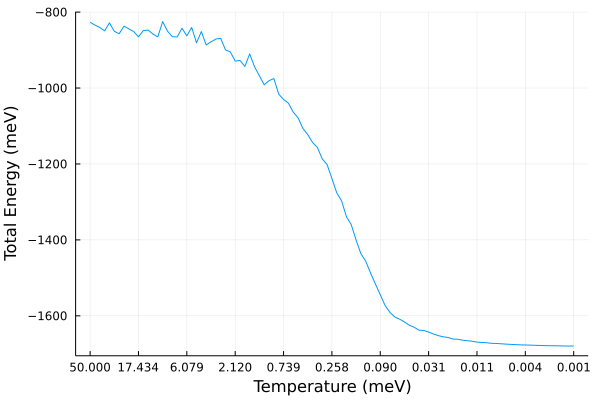

In [180]:
xtickvals = kTs[1:10:end]

Plots.plot(kTs, Es[end:-1:1];  xlabel="Temperature (meV)",
                ylabel="Total Energy (meV)", 
                label=false,
                xscale=:log10,
                xticks=(xtickvals, [format("{:.3f}", x) for x ∈ xtickvals][end:-1:1])
)

We seem to have reached at least a local mininimum.  The actual ground state for this material is known. It is a striped configurations. Each stripe is two spins wide, and the polarization of the stripes alternates. The axis of polarization is nearly the z-axis, but the spins are canted away from this axis slightly.

Let us take a look at the spin configuration that we have found to see if it matches this description. Sunny provides a function, `plot_spins`, for inspecting spin configurations. Note that it requires the `GLMakie` package. If run outside of the notebook environment, `plot-spins` will allow you to interactive zoom and pan.

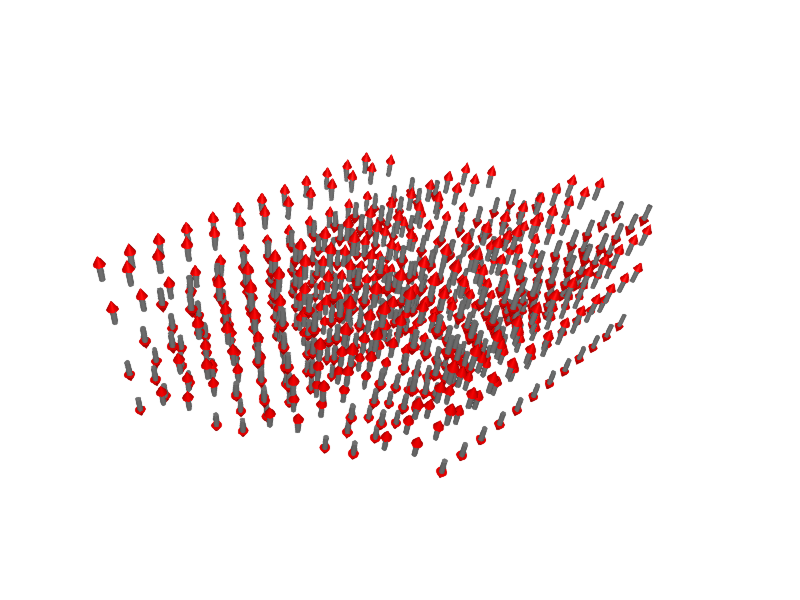

In [181]:
plot_spins(sys; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

Hopefully you see a result that matches the description given above. If not, try running a few times until you do. It's not uncommon to encounter domain formation. Sunny has a number of powerful tools for dealing with these situations, which you can learn above in forthcoming tutorials. If you are working on a slower computer, you may also consider working with a smaller system size to speed up the calculation, e.g., 8x8x4.

## Calculating a Dynamical Structure Factor

With our ground state in hand, we can begin to perform the calculations to create a dynamical spin structure factor (DSSF).  This is useful for direct comparison with neutron scattering data.

The basic procedure consists of the following. Initial conditions are created by thermalizing ground states. These initial conditions are then used to calculate full dynamical trajectories, which are recorded and subsequently Fourier transformed to produce a DSSF. Further details can be found [here](https://sunnysuite.github.io/Sunny.jl/dev/structure-factor/). To keep things simple, in the remainder of this tutorial we will go through these basic steps just outlined for a single initial condition. To achieve full publication-quality results, it is only necessary to use a larger system and many more initial conditions. You may also wish to apply various correction factors for comparison with experimental data.

We begin by defining a function that calculates the sum of the diagonal elements of the DSSF from a single trajectory. This involves extracting each component from the dipoles (x, y and z), Fourier transforming the results over both space and time, and then summing the results.

In [197]:
using StaticArrays
using FFTW

function symmetric_dssf(dipoles)
      # Extract x-, y- and z-components of spin dipoles
      spin_coords = [map(s -> s[i], dipoles) for i ∈ 1:3]  
      
      # Perform an FFT on each array of components
      S = map(x -> fft(x)/(*(size(x)...)), spin_coords) 
      
      # Calculate the magnitude squared of FFTs
      SS = map(S -> real.(S .* conj.(S)), S)

      # Sum diagonal elements of DSSF
      sum(SS)
end;

### Thermalizing the System and Collecting Trajectories

To thermalize the system, we simply simulate the dynamics for a stretch with the Langevin thermostat set to the temperature of interest. We are going to explore the DSSF near zero temperature, so we will set kT to a very small value. (Since Sunny performs a classical simulation -- essentially a generalization of the Landau-Lifshitz equations-- there are no quantum fluctuations. Because of this, if we start at a ground state, there will be no dynamics at zero temperature.)

After we have thermalized the spin system, we will use whatever state the spin system is in as an initial condition. To calculate the trajectory, we will use a sympletic integration scheme to ensure that there is no energy drift in the simulation. Sunny provides the `SchrodingerMidpoint` integrator for this purpose \[2\].

Once we have a trajectory, we can calculate the DSSF using the function defined in the previous section. One usually prefers to average over many different trajectories, each started from a different intial condition.

The function below wraps all these steps together.

In [124]:
function calculate_dssf(sampler, kT, Δt, dur; num_samples=2)
    sys = sampler.integrator.sys
    dims = size(sys)[1:3]
    num_steps = round(Int, dur/Δt)
    dipoles = zeros(SVector{3, Float64}, dims..., num_steps)
    𝒮 = zeros(dims..., num_steps)
    
    set_temp!(sampler, kT)
    integrator = SchrodingerMidpoint(sys)
    
    for i ∈ 1:num_samples    
        # Thermalize the system
        sample!(sampler) 
        
        # Calculate the trajectory, saving dipole moments
        for j ∈ 1:num_steps
            evolve!(integrator, Δt)
            copyto!(@view(dipoles[:,:,:,j]), sys._dipoles[:,:,:,1])
        end
        
        # Calculating DSSF from new trajectory
        𝒮_new = symmetric_dssf(dipoles)
        
        # Calculate running average of DSSF
        @. 𝒮 = ((i-1)/num_samples) * 𝒮 + (i/num_samples) * 𝒮_new
    end
    
    return 𝒮
end;

We now set the duration of the trajectory and the step size for the integrator. Note that the step size for this integrator can be larger than what was used for the Langevin integration. Remember that the step size will determine the highest energy level that can be resolved, and the duration of the simulation will determine how fine the energy resolution is. You may wish to experiment with these parameters, but keep in mind that the step size has to be kept small enough that the integrator remains stable.

In [198]:
dur_trajectory = 100.0
Δt = 0.05 
kT = 0.001

𝒮 = calculate_dssf(langevin_sampler, kT, Δt, dur_trajectory; num_samples=20);

### Processing and Plotting

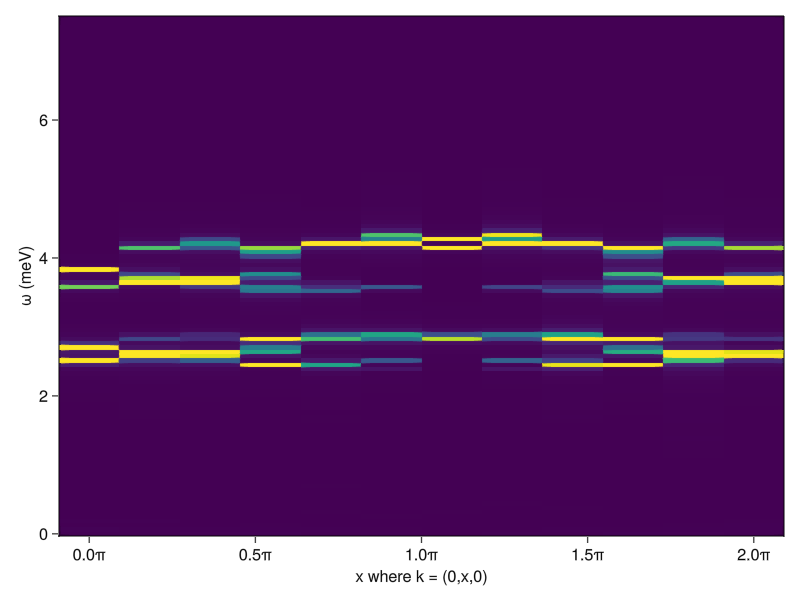

In [206]:
nsteps = size(𝒮)[end]
ω_max = 2π/Δt
Δω = ω_max/nsteps
ωs = collect(0:nsteps-1) .* Δω
ks = collect(0:dims[2]-1) .* (2π/(dims[2]-1))

fig = Figure()
axis = Axis(fig[1,1], xlabel="x where k = (0,x,0)", ylabel="ω (meV)", xticks=MultiplesTicks(5, pi, "π"))

heatmap!(axis, ks, ωs[1:120], 𝒮[1,:,1,1:120];
        colorrange = (0, 3e-7))
        
fig

## References
\[1\] Bai et al., _Hybridized quadrupolar excitations in the spin-anisotropic frustrated magnet FeI2_, Nature Physics v. 17 (2021). (https://doi.org/10.1038/s41567-020-01110-1)

\[2\] Dahlbom et al., _Geometric integration of classical spin dynamics via a mean-field Schrödinger equation_ [arXiv:2204.07563](https://arxiv.org/abs/2204.07563).